In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# nvcc version 확인
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!nvidia-smi

Wed Dec  4 05:40:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# 필수 Package import
import os
import glob
import random
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1,2,3"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
print('Device:', device)
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Count of using GPUs: 1


In [ ]:
# 이미지를 출력하는 함수
def display_images(image_paths, title, max_images=4):
    """지정된 경로의 이미지를 최대 4개까지 출력합니다."""
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

In [ ]:
# 이미지와 바 그래프 출력
categories = ['Train ai', 'Train real', 'Val ai', 'Val real', 'Test ai', 'Test real']

for category in categories:
    image_paths = glob.glob(f'/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/7/{category.lower().replace(" ", "/")}/*')
    display_images(image_paths, category)
    print(f"{category} 총 이미지 수: {len(image_paths)}")

# 바 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/7/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from imgaug import augmenters as iaa
import imgaug as ia

# imgaug를 사용한 커스텀 데이터셋 정의
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Fliplr(0.5),  # 50% 확률로 좌우 반전
            iaa.Affine(rotate=(-20, 20), mode='symmetric'),  # -20도에서 20도 사이로 회전
        ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

In [ ]:
# 커스텀 데이터셋 클래스
class CustomDataset(ImageFolder):
    def __init__(self, root, imgaug=None, transform=None, sample_per_class=None):
        super(CustomDataset, self).__init__(root, transform=transform)
        self.imgaug_transform = imgaug  # imgaug 매개변수를 직접 저장

        if sample_per_class is not None:
            self.samples = self._reduce_samples(sample_per_class)

    def _reduce_samples(self, sample_per_class):
        class_samples = {}
        for path, target in self.samples:
            if target not in class_samples:
                class_samples[target] = [path]
            else:
                class_samples[target].append(path)

        reduced_samples = []
        for target, paths in class_samples.items():
            if len(paths) > sample_per_class:
                reduced_samples.extend([(path, target) for path in random.sample(paths, sample_per_class)])
            else:
                reduced_samples.extend([(path, target) for path in paths])


        return reduced_samples

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        # imgaug 증강 적용
        if self.imgaug_transform is not None:
            img = self.imgaug_transform(img)
            # imgaug는 numpy 배열을 반환하므로, PIL Image로 다시 변환
            img = Image.fromarray(img)

        # ToTensor 및 Normalize 적용
        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [ ]:
# PyTorch transforms에서 ToTensor 및 Normalize만 적용
from torchvision import transforms
pytorch_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# 데이터셋 및 데이터 로더 초기화
train_dataset = CustomDataset('/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/7/train', imgaug=ImgAugTransform(), transform=pytorch_transforms)
val_dataset = CustomDataset('/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/7/val', imgaug=None, transform=pytorch_transforms, sample_per_class=64)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

In [ ]:
# DataLoader에서 샘플을 이미지를 load해 show하는 함수
def imshow(img, labels, class_to_idx, size=(20, 20), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    # idx_to_class를 생성합니다: 인덱스를 클래스 이름으로 매핑
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean  # 역정규화
    img = np.clip(img, 0, 1)  # 값이 0과 1 사이에 오도록 클리핑
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')

    # 이미지 위에 레이블 번호와 실제 클래스 이름 출력
    for i, label in enumerate(labels[:8]):  # 첫 8개의 이미지에 대해서만 실행
        class_name = idx_to_class[label.item()]
        x = (i % 4) * (img.shape[1] // 4) + 100  # 텍스트 x 위치
        y = (i // 4) * (img.shape[0] // 2) + 10  # 텍스트 y 위치
        plt.text(x, y, f'{label.item()}, {class_name}', color='black', fontsize=14)

    plt.show()

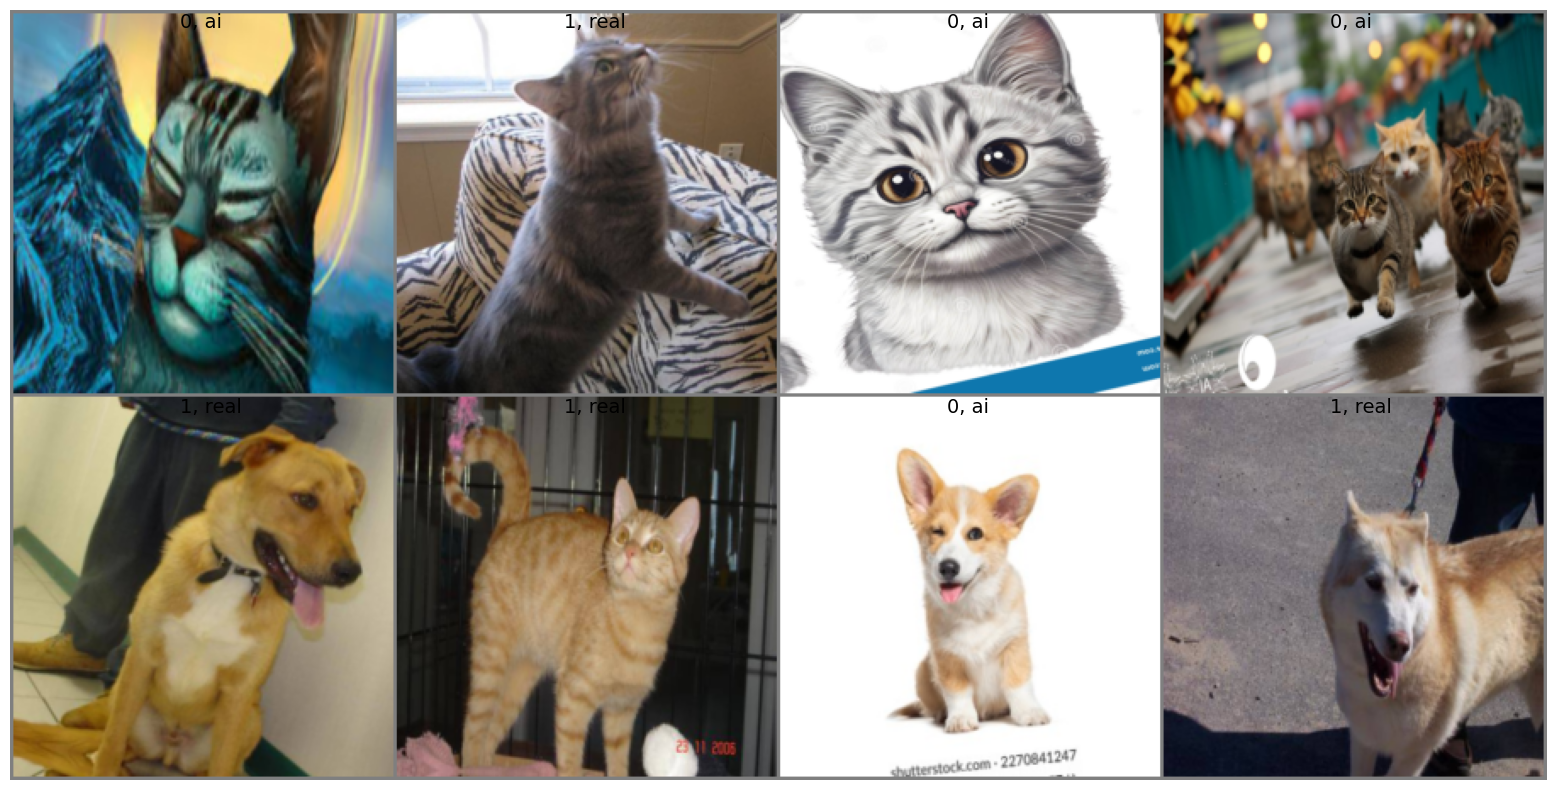

In [ ]:
# DataLoader를 이용하여 배치 데이터 가져오기
dataiter = iter(train_loader)
images, label = next(dataiter)

# 이미지 그리드 생성 및 시각화, nrow를 조정하여 한 줄에 표시되는 이미지의 수 조정
class_to_idx = train_loader.dataset.class_to_idx  # DataLoader에서 class_to_idx 매핑 가져오기

imshow(make_grid(images[:8], nrow=4), label, class_to_idx, size=(20, 10))

In [ ]:
# Alexnet 모델 로드 및 네트워크 구조 확인
alexnet = models.alexnet(pretrained=True)

# 모델의 모든 파라미터를 고정
for param in alexnet.parameters():
    param.requires_grad = False

# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
alexnet.classifier[6] = nn.Linear(4096, 1)
alexnet.classifier[6].requires_grad = True

alexnet = alexnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 161MB/s]


In [ ]:
# 손실 함수
criterion = nn.BCEWithLogitsLoss()

In [ ]:
def validate_model(net, val_loader, criterion):
    net.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # 레이블을 float 타입으로 변환 및 차원 맞춤
            outputs = net(inputs)
            val_loss += criterion(outputs, labels).item()
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [ ]:
import torch.optim as optim

def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    # optimizer설정
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.00003, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # 학습/검증 손실과 검증 정확도를 저장할 리스트
    train_losses = []
    val_losses = []
    val_accuracies = []


    for epoch in range(num_epochs):
        net.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # 레이블을 float 타입으로 변환 및 차원 맞춤
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        # 매 에포크마다 평균 학습 손실 계산
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 검증 손실 및 정확도 계산
        val_loss, val_accuracy = validate_model(net, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')


    return train_losses, val_losses, val_accuracies

In [ ]:
train_losses_alexnet, val_losses_alexnet, val_accuracies_alexnet = train_model('RAdam', alexnet, train_loader, val_loader, criterion)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[RAdam] Epoch 1, Train Loss: 0.772347, Val Loss: 0.737456, Validation Accuracy: 49.22%
[RAdam] Epoch 2, Train Loss: 0.741793, Val Loss: 0.709170, Validation Accuracy: 52.34%
[RAdam] Epoch 3, Train Loss: 0.702658, Val Loss: 0.677184, Validation Accuracy: 57.03%
[RAdam] Epoch 4, Train Loss: 0.660860, Val Loss: 0.644043, Validation Accuracy: 60.94%
[RAdam] Epoch 5, Train Loss: 0.624263, Val Loss: 0.611062, Validation Accuracy: 68.75%
[RAdam] Epoch 6, Train Loss: 0.595966, Val Loss: 0.578769, Validation Accuracy: 73.44%
[RAdam] Epoch 7, Train Loss: 0.563354, Val Loss: 0.546721, Validation Accuracy: 74.22%
[RAdam] Epoch 8, Train Loss: 0.532259, Val Loss: 0.517726, Validation Accuracy: 80.47%
[RAdam] Epoch 9, Train Loss: 0.507469, Val Loss: 0.488885, Validation Accuracy: 83.59%
[RAdam] Epoch 10, Train Loss: 0.490620, Val Loss: 0.463417, Validation Accuracy: 85.16%
[RAdam] Epoch 11, Train Loss: 0.461044, Val Loss: 0.439129, Validation Accuracy: 86.72%
[RAdam] Epoch 12, Train Loss: 0.438865, V

In [ ]:
# VGG 모델 로드 및 네트워크 구조 확인
vgg = models.vgg19(pretrained=True)

# 모델의 모든 파라미터를 고정
for param in vgg.parameters():
    param.requires_grad = False

# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
vgg.classifier[6] = nn.Linear(4096, 1)
vgg.classifier[6].requires_grad = True

vgg = vgg.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 174MB/s]


In [ ]:
train_losses_vgg, val_losses_vgg, val_accuracies_vgg = train_model('RAdam', vgg, train_loader, val_loader, criterion)

[RAdam] Epoch 1, Train Loss: 0.711918, Val Loss: 0.697221, Validation Accuracy: 52.34%
[RAdam] Epoch 2, Train Loss: 0.697363, Val Loss: 0.684747, Validation Accuracy: 57.03%
[RAdam] Epoch 3, Train Loss: 0.695172, Val Loss: 0.668875, Validation Accuracy: 60.94%
[RAdam] Epoch 4, Train Loss: 0.666202, Val Loss: 0.650968, Validation Accuracy: 66.41%
[RAdam] Epoch 5, Train Loss: 0.651928, Val Loss: 0.631533, Validation Accuracy: 69.53%
[RAdam] Epoch 6, Train Loss: 0.629701, Val Loss: 0.611162, Validation Accuracy: 72.66%
[RAdam] Epoch 7, Train Loss: 0.602592, Val Loss: 0.590050, Validation Accuracy: 78.12%
[RAdam] Epoch 8, Train Loss: 0.589048, Val Loss: 0.567652, Validation Accuracy: 82.81%
[RAdam] Epoch 9, Train Loss: 0.565962, Val Loss: 0.547323, Validation Accuracy: 82.81%
[RAdam] Epoch 10, Train Loss: 0.548251, Val Loss: 0.527179, Validation Accuracy: 85.94%
[RAdam] Epoch 11, Train Loss: 0.527796, Val Loss: 0.507089, Validation Accuracy: 85.94%
[RAdam] Epoch 12, Train Loss: 0.511157, V

In [ ]:
# Resnet 모델 로드 및 네트워크 구조 확인
resnet = models.resnet50(pretrained=True)

# 모델의 모든 파라미터를 고정
for param in resnet.parameters():
    param.requires_grad = False

# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
resnet.fc = nn.Linear(2048, 1)
resnet.fc.requires_grad = True

resnet = resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


In [33]:
train_losses_resnet, val_losses_resnet, val_accuracies_resnet = train_model('RAdam', resnet, train_loader, val_loader, criterion)

[RAdam] Epoch 1, Train Loss: 0.660814, Val Loss: 0.673287, Validation Accuracy: 59.38%
[RAdam] Epoch 2, Train Loss: 0.657525, Val Loss: 0.667238, Validation Accuracy: 61.72%
[RAdam] Epoch 3, Train Loss: 0.647866, Val Loss: 0.658382, Validation Accuracy: 63.28%
[RAdam] Epoch 4, Train Loss: 0.638716, Val Loss: 0.646529, Validation Accuracy: 63.28%
[RAdam] Epoch 5, Train Loss: 0.629315, Val Loss: 0.635022, Validation Accuracy: 65.62%
[RAdam] Epoch 6, Train Loss: 0.621010, Val Loss: 0.619812, Validation Accuracy: 67.19%
[RAdam] Epoch 7, Train Loss: 0.609650, Val Loss: 0.609442, Validation Accuracy: 67.19%
[RAdam] Epoch 8, Train Loss: 0.599278, Val Loss: 0.593722, Validation Accuracy: 74.22%
[RAdam] Epoch 9, Train Loss: 0.583856, Val Loss: 0.580036, Validation Accuracy: 76.56%
[RAdam] Epoch 10, Train Loss: 0.572797, Val Loss: 0.565668, Validation Accuracy: 82.03%
[RAdam] Epoch 11, Train Loss: 0.558438, Val Loss: 0.555191, Validation Accuracy: 79.69%
[RAdam] Epoch 12, Train Loss: 0.549220, V

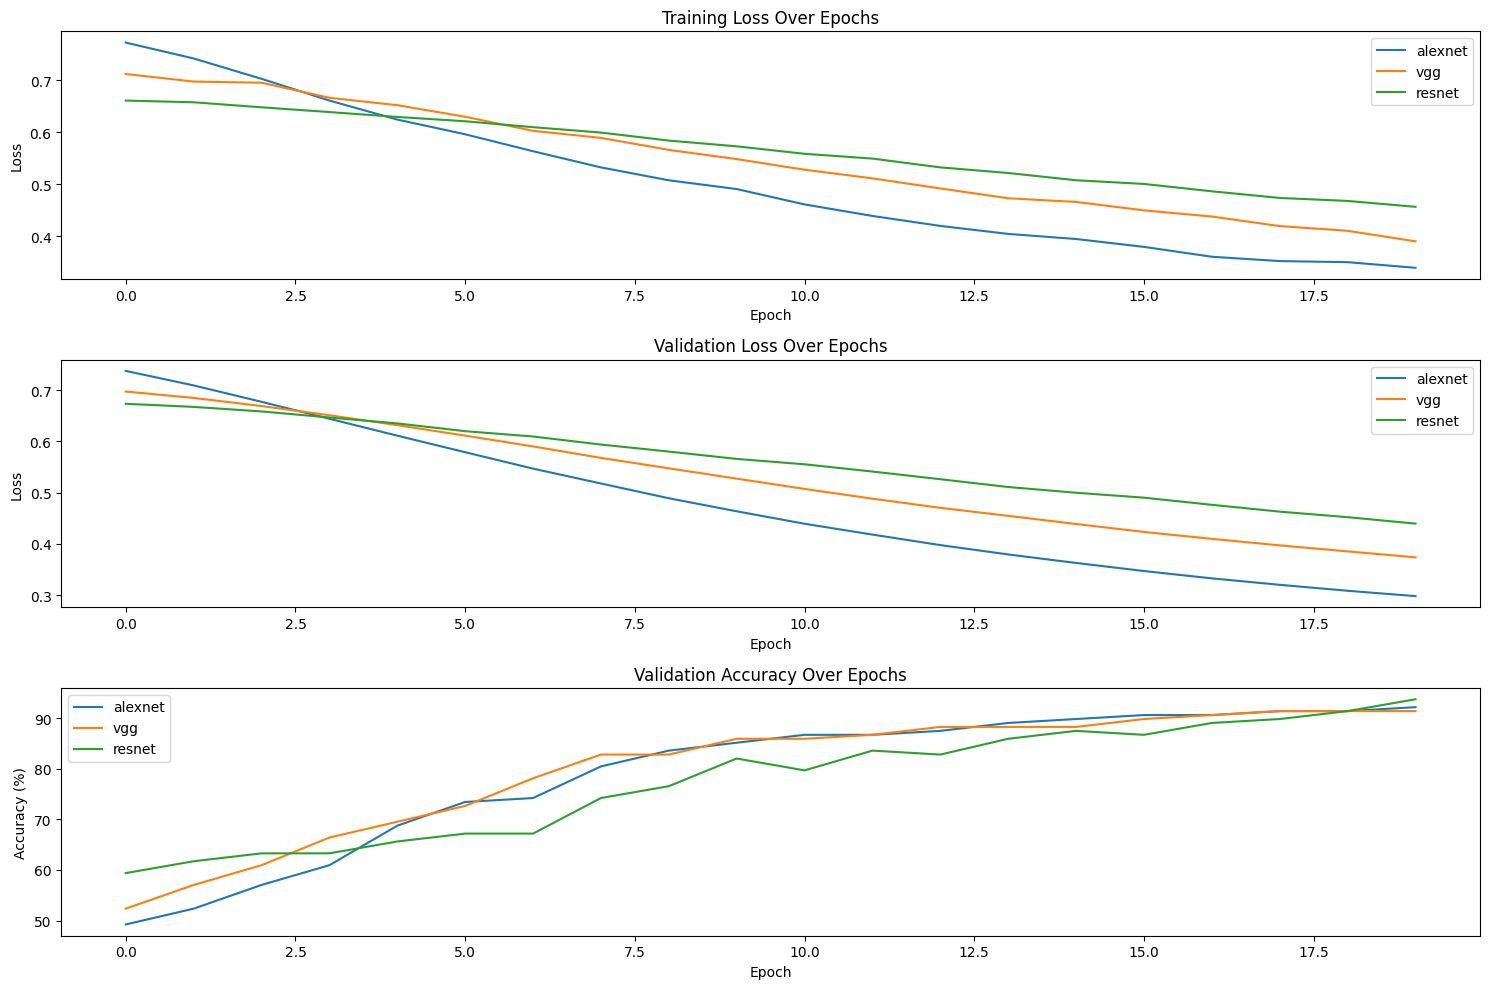

In [34]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_alexnet, label='alexnet')
plt.plot(train_losses_vgg, label='vgg')
plt.plot(train_losses_resnet, label='resnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_alexnet, label='alexnet')
plt.plot(val_losses_vgg, label='vgg')
plt.plot(val_losses_resnet, label='resnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_alexnet, label='alexnet')
plt.plot(val_accuracies_vgg, label='vgg')
plt.plot(val_accuracies_resnet, label='resnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
# Image load 및 tensor로 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)  # 이미지를 모델에 맞게 변환하고 배치 차원 추가

In [36]:
# 클래스별 폴더 경로
class_folders = {
    'ai': '//content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/7/test/ai',
    'real': '/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/7/test/real'
}

plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, pytorch_transforms)

        resnet.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = resnet(image)
            # 시그모이드 함수 적용하여 확률 얻기
            probs = torch.sigmoid(outputs).item()
            prediction = 'real' if probs >= 0.5 else 'ai'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, class_folders, transform):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    for class_name, folder_path in class_folders.items():
        image_paths = glob.glob(os.path.join(folder_path, '*'))

        for image_path in image_paths:
            image = load_and_transform_image(image_path, transform)

            with torch.no_grad():
                outputs = model(image)
                probs = torch.sigmoid(outputs).item()
                prediction = 1 if probs >= 0.5 else 0
                all_preds.append(prediction)
                all_labels.append(1 if class_name == 'real' else 0)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return accuracy, precision, recall, f1


# Evaluate models
alexnet_metrics = evaluate_model(alexnet, class_folders, pytorch_transforms)
vgg_metrics = evaluate_model(vgg, class_folders, pytorch_transforms)
resnet_metrics = evaluate_model(resnet, class_folders, pytorch_transforms)

# Print comparison
print("AlexNet Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*alexnet_metrics))
print("VGGNet19 Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*vgg_metrics))
print("ResNet50 Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*resnet_metrics))

AlexNet Metrics: Accuracy: 0.8750, Precision: 0.8571, Recall: 0.9000, F1: 0.8780
VGGNet19 Metrics: Accuracy: 0.9250, Precision: 0.9048, Recall: 0.9500, F1: 0.9268
ResNet50 Metrics: Accuracy: 0.9000, Precision: 0.8636, Recall: 0.9500, F1: 0.9048


AlexNet
VGGNet19
ResNet50

데이터셋이 한정되어 있고
Epoch 수가 적어서 모델 성능이 비교적 비슷하게 나옴
Accuracy는 Resnet이 가장 좋은 성능을 보임
F1은 VGGNet19이 가장 좋은 성능을 보임

Loss function :  

- nn.BCELoss 사용할 경우
출력층 : sigmoid 넣어야됨(Loss function에 없음)

-  nn.BCEWithLogitsLoss 사용할 경우
출력층 : sigmoid 안넣어도 됨(Loss function에 포함되어 있음)

- nn.CrossEntropyLoss 사용할 경우
출력층 : sigmoid 넣어야됨(Loss function에 없음)






